# Basic Demo and debugging of the xQAOA solver. 

## Problem Setup and Classical Solutions

First we load the solver and some basic tools. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time
from tqdm import tqdm

from scripts.solvers.qkp_solver import *
from scripts.utils.kp_utils import *
from ADMM.scripts.solvers.classical_solver_UC import gurobi_knapsack_solver
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Pauli
from qiskit.transpiler.passes import LightCone, RemoveBarriers
from qiskit.transpiler import PassManager
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import Operator
from qiskit.quantum_info import SparsePauliOp

Then lets initialize our hard knapsack distribution, including the capacity constraint. We end with a plot of all the items in the knapsack and their values and weights.

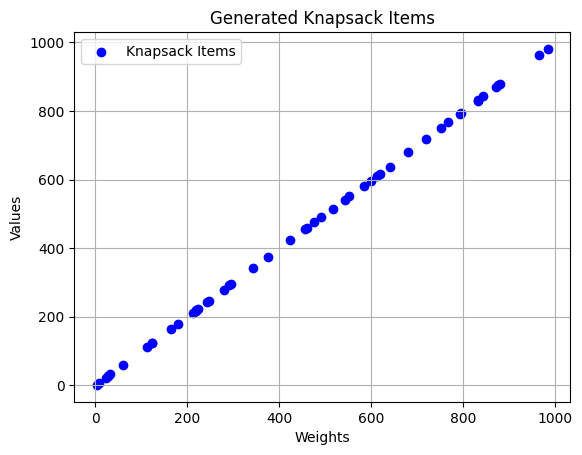

In [60]:
n = 50  # Number of items
d = 4  # Technical term in definition of profit distribution setting how far values can differ from weights
[weights,values] = generate_profit(n, d) # create the list of knapsack items
capacity = 0.7 * np.sum(weights)  # Set weight limit to 70% of total weight

# Plot the knapsack items
plt.scatter(weights, values, color='blue', marker='o', label='Knapsack Items')
plt.title('Generated Knapsack Items')
plt.xlabel('Weights')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

Note the relationship between items weight and their value is essentially linear with value equal to the weight rounded down to the nearest multiple of $d$. 

A useful way to visualize this is to plot the ratio of value/weight against the weights. 

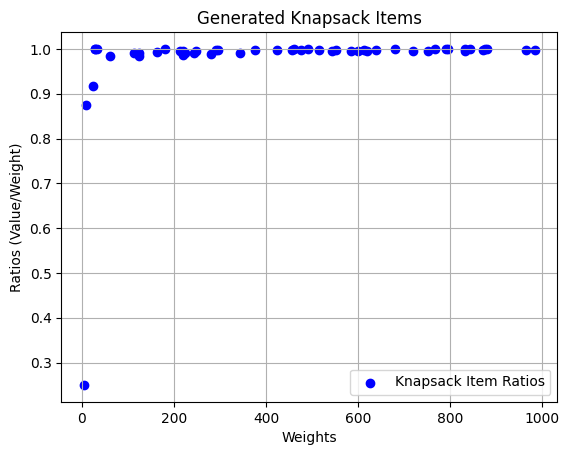

In [61]:
ratios = values / weights
plt.scatter(weights, ratios, color='blue', marker='o', label='Knapsack Item Ratios')
plt.title('Generated Knapsack Items')
plt.xlabel('Weights')
plt.ylabel('Ratios (Value/Weight)')
plt.legend()
plt.grid(True)
plt.show()

Now lets solve the problem with Gurobi and plot the optimal solution.

Knapsack Capacity: 15688.4
Total Value of optimal solution: 15662
Total Weight of optimal solution: 15688
Runtime: 0.034000 seconds


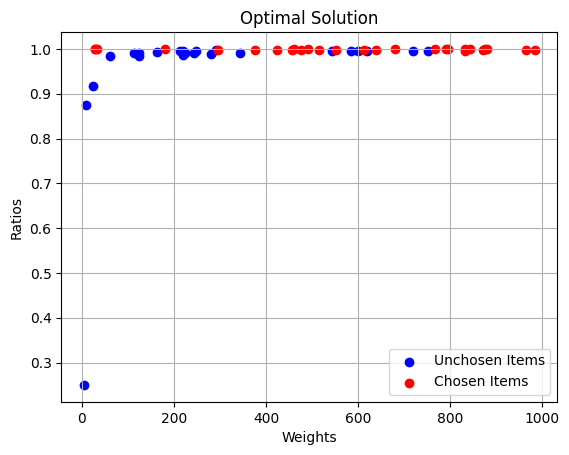

In [62]:
# Solve the knapsack problem using Gurobi
result_gurobi = gurobi_knapsack_solver(values, weights, capacity, verbose=False,
                                        time_limit=60,
                                        optimality_gap=1e-20,
                                        feasibility_tolerance=1e-9)

optimal_value = result_gurobi['total_value']
optimal_weight = result_gurobi['total_weight']

# And print some output statistics
# print(f"Optimization Results Gurobi -- {n} items")
# print(f"Bitstring: {result_gurobi['bitstring']}")
print(f"Knapsack Capacity: {capacity}")
print(f"Total Value of optimal solution: {result_gurobi['total_value']}")
print(f"Total Weight of optimal solution: {result_gurobi['total_weight']}")
print(f"Runtime: {result_gurobi['runtime']:.6f} seconds")

# Lets also plot the Gurobi solutions
soln_mask = np.array([c == '1' for c in result_gurobi['bitstring']], dtype=bool)
plt.figure()
plt.scatter(weights[~soln_mask], ratios[~soln_mask],  color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[soln_mask], ratios[soln_mask],  color='red', marker='o', label='Chosen Items')
plt.title('Optimal Solution')
plt.ylabel('Ratios')
plt.xlabel('Weights')
plt.legend()
plt.grid(True)
plt.show()

As a sanity check, lets construct the greedy solution and see how it compares to Gurobi. 

Greedy Solution Value: 15657
Greedy Solution Weight: 15688


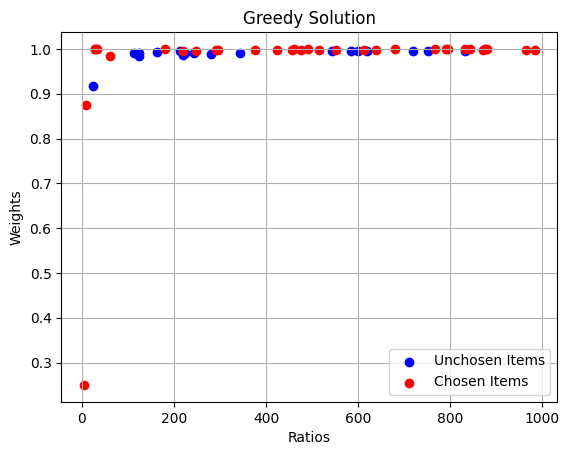

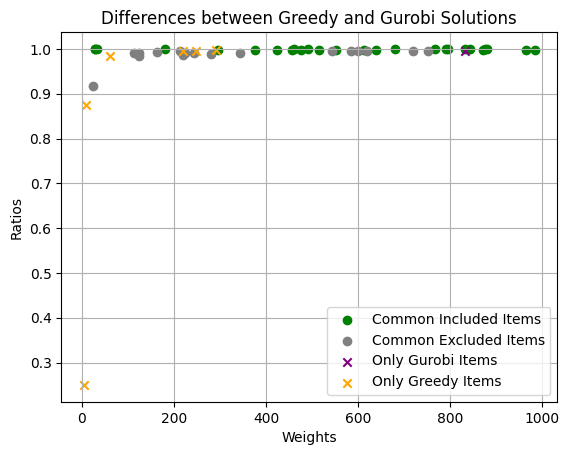

In [63]:
greedy_weight = 0
greedy_solution = np.zeros(n, dtype=bool)

# Order items by their ratio with weight as the tiebreaker
greedy_order = np.lexsort((-weights, -ratios))

for i in greedy_order:
    if greedy_weight + weights[i] <= capacity:
        greedy_solution[i] = True
        greedy_weight += weights[i]
    
greedy_value = np.sum(values[greedy_solution])
print(f"Greedy Solution Value: {greedy_value}")
print(f"Greedy Solution Weight: {greedy_weight}")
# Plot the greedy solution
plt.figure()
plt.scatter(weights[~greedy_solution], ratios[~greedy_solution], color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[greedy_solution], ratios[greedy_solution], color='red', marker='o', label='Chosen Items')
plt.title('Greedy Solution')
plt.xlabel('Ratios')
plt.ylabel('Weights')
plt.legend()
plt.grid(True)
plt.show()

# Plot the indices where the greedy solution and Gurobi solution differ
diff_indices = np.logical_xor(greedy_solution, soln_mask)
diff_gurobi_solutions = np.logical_and(soln_mask, diff_indices)
diff_greedy_solutions = np.logical_and(greedy_solution, diff_indices)
common_solutions = np.logical_and(greedy_solution, soln_mask)
common_excluded = np.logical_and(~greedy_solution, ~soln_mask)
plt.figure()
plt.scatter(weights[common_solutions], ratios[common_solutions], color='green', marker='o', label='Common Included Items')
plt.scatter(weights[common_excluded], ratios[common_excluded], color='gray', marker='o', label='Common Excluded Items')
plt.scatter(weights[diff_gurobi_solutions], ratios[diff_gurobi_solutions], color='purple', marker='x', label='Only Gurobi Items')
plt.scatter(weights[diff_greedy_solutions], ratios[diff_greedy_solutions], color='orange', marker='x', label='Only Greedy Items')
plt.title('Differences between Greedy and Gurobi Solutions')
plt.xlabel('Weights')
plt.ylabel('Ratios')
plt.legend()
plt.grid(True)
plt.show()


## Quantum Solution

### Classical Warm Start Distribution

Our starting point for the Quantum Solution is a classical warm start. 

To understand this distribution we first construct the "lazy greedy" classical solution. This is obtained similarly to the greedy classical solution constructed above, only the algorithm stops when it encounters the first item that doesn't fit into the knapsack.

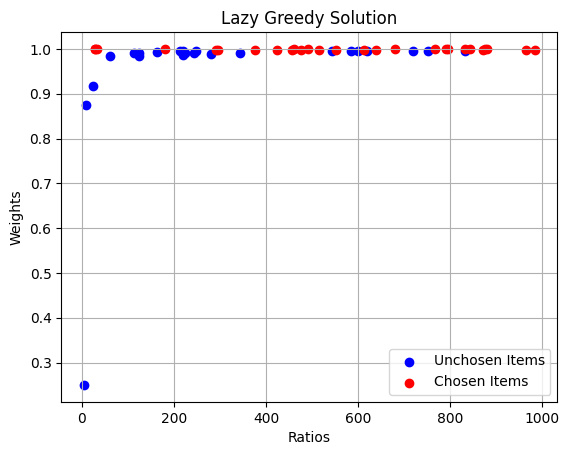

In [64]:
def construct_lazy_greedy_solution(weights, ratios, capacity):
    # Constructs a lazy greedy solution
    lazy_greedy_weight = 0
    lazy_greedy_solution = np.zeros(n, dtype=bool)

    # Order items by their ratio with weight as the tiebreaker
    greedy_order = np.lexsort((-weights, -ratios))

    for i in greedy_order:
        if lazy_greedy_weight + weights[i] <= capacity:
            lazy_greedy_solution[i] = True
            lazy_greedy_weight += weights[i]
        else:
            break
    return lazy_greedy_solution

lgs = construct_lazy_greedy_solution(weights, ratios, capacity)
plt.figure()
plt.scatter(weights[~lgs], ratios[~lgs], color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[lgs], ratios[lgs], color='red', marker='o', label='Chosen Items')
plt.title('Lazy Greedy Solution')
plt.xlabel('Ratios')
plt.ylabel('Weights')
plt.legend()
plt.grid(True)
plt.show()



This solution will never be better than the greedy solution visualized above, but it does give us a useful starting point for constructing our warm start distribution. 

As a first step, notice that if we sort items by ratio of (value/weight) the lazy greedy distribution has a cutoff above which all items are included in the solution, and below which items are excluded. 

In the next plot we visualize this as giving a `probability' (either 0 or 1) of being included in the lazy greedy solution. This is to prepare us for the warm start distribution, which we define next. 



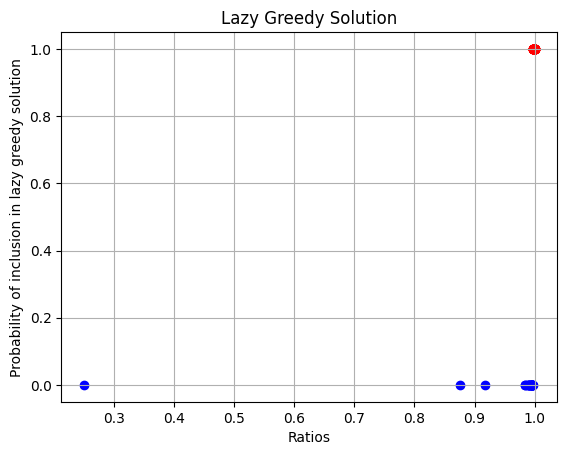

In [65]:
plt.figure()
plt.scatter(ratios[~lgs], np.zeros_like(values[~lgs]), color='blue', marker='o', label='Unchosen Items')
plt.scatter(ratios[lgs], np.ones_like(values[lgs]), color='red', marker='o', label='Unchosen Items')
plt.title('Lazy Greedy Solution')
plt.xlabel('Ratios')
plt.ylabel('Probability of inclusion in lazy greedy solution')
plt.grid(True)
plt.show()

Our warm start distribution can now be obtained by "smoothing out" the above probabilities slightly. It is defined in terms of an inverse temperature parameter k. Setting k = infinity produces the lazy greedy distribution above, while setting k = 0 produces a uniform distribution with expected weight equal to the capacity of knapsack. 

C:\Users\adamb\AppData\Local\Temp\ipykernel_5792\2917671064.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + (uniform_probability - 1) * np.exp(-inv_temp * (ratios - cutoff_ratio)))


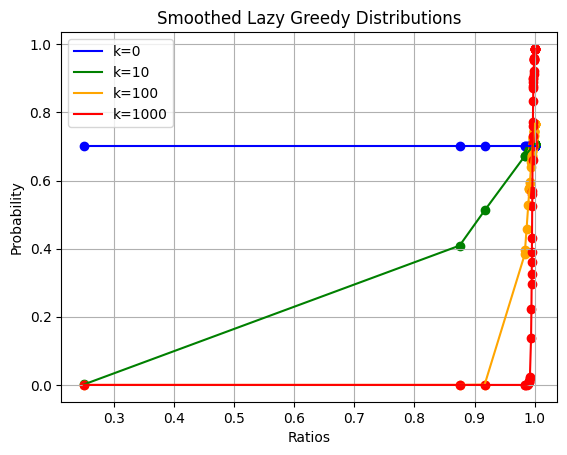

In [66]:

def construct_smoothed_lazy_greedy_distribution(weights, values, capacity, inv_temp):
    # First find the cutoff ratio for the lazy greedy solution.
    lazy_greedy_solution = construct_lazy_greedy_solution(weights, values / weights, capacity)
    cutoff_ratio = np.min(ratios[lazy_greedy_solution]) 
    # Then set some constants so that in the limit of k = 0 we have the correct uniform distribution.
    uniform_probability = np.sum(weights) / capacity

    return 1 / (1 + (uniform_probability - 1) * np.exp(-inv_temp * (ratios - cutoff_ratio)))

# Lets plot some solutions for different values of k
k_values = [0, 10, 100, 1000]
colours = ['blue', 'green', 'orange', 'red']
plt.figure()
for i in range(len(k_values)):
    smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k_values[i])
    plt.scatter(ratios, smoothed_distribution, color=colours[i], marker='o')
    # plot a line through the points
    ordered_indices = np.argsort(ratios)
    plt.plot(ratios[ordered_indices], smoothed_distribution[ordered_indices], color=colours[i], label=f'k={k_values[i]}')
plt.title('Smoothed Lazy Greedy Distributions')
plt.xlabel('Ratios')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()


Note that our "solution" is now a probability distribution. We can repeatedly sample from this distribution to understand the quality of the solutions our warm start gives. An important observation is that this distribution will sometimes give solutions which do not respect the capacity restraints of thte knapsack. We must filter those out to get an accurate understanding of the solution quality.  

Best valid solution value is: 15649
Worst invalid solution is: 15644
Optimal solution value is: 15662
Probability of valid samples: 0.462
Approximation ratio of valid samples: 0.9155


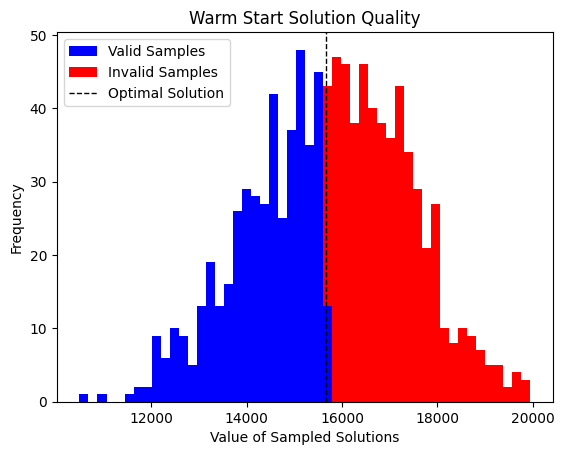

In [67]:
# We will pick k = 100 since it gives a gives a good balance between the uniform and lazy greedy distributions.
k = 100
smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k)

# Now sample from this distribtion
num_samples = 1000
samples = np.random.rand(num_samples, len(weights)) < smoothed_distribution
total_values = np.sum(samples * values, axis=1)
total_weights = np.sum(samples * weights, axis=1)
valid_samples = total_weights <= capacity

# Some nice to have statistics
probability_valid = np.sum(valid_samples) / num_samples
approxmation_ratio_of_valid = np.mean(total_values[valid_samples]) / optimal_value

# Lets make a histogram showing the total value of the samples
plt.figure()
plt.hist([total_values[valid_samples],total_values[~valid_samples]], bins=50, stacked = True, color=['blue','red'], label=['Valid Samples', 'Invalid Samples'])
plt.axvline(optimal_value, color='black', linestyle='dashed', linewidth=1, label='Optimal Solution')
plt.title('Warm Start Solution Quality')
plt.xlabel('Value of Sampled Solutions')
plt.ylabel('Frequency')
plt.legend()

print(f"Best valid solution value is: {np.max(total_values[valid_samples])}")
print(f"Worst invalid solution is: {np.min(total_values[~valid_samples])}")
print(f"Optimal solution value is: {optimal_value}")
print(f"Probability of valid samples: {probability_valid}")
print(f"Approximation ratio of valid samples: {approxmation_ratio_of_valid:.4f}")

The fundamental question we investigate next is whether we can improve performance of our solution by postprocessing the distribution with a quantum circuit. 

### Preparing Warm Start Distribution on a Quantum Computer 

In our quantum circuit, each qubit will represent one item in the knapsack. At the end of the circuit we measure all the qubits to produce a solution to the knapsack problem -- if a qubit is measured in the $\ket{1}$ state then the corresponding item will be in the napsack solution, and if is measured in the $\ket{0}$ state the corresponding item will be excluded from the soltuion. 

The first step then, is to initialize a quantum circuit with as many qubits as we have potential items to put in the knapsack. Then we prepare those qubits in a state whose measurement statistics match the warm start distribution described above on a quantum computer. We do this by rotating each qubit about the Y-axis to produce the state $\sqrt{1-p_i}\ket{0} + \sqrt{p_i}\ket{1}$ where $p_i$ is the probability the warm start distribution assignes to the $i$-th item. 

An important detail when we move on to constructing the xQAOA mixer will be the physical layout of our qubits. We order our qubits in terms of increasing ratio, so that adjacent qubits correspond to items with similar ratios of value/weight. When items have an idential ratio we use weight as a tiebreaker.

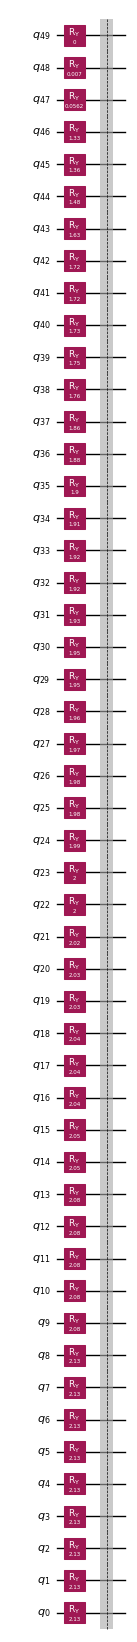

In [87]:
warm_start_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k)
qubit_order = np.lexsort((-weights, -ratios))

qubit_ordered_distribution = warm_start_distribution[qubit_order]

qc = QuantumCircuit(n)

def initialize_warm_start_distribution(quantum_circuit, distribution):
    """
    Initializes the quantum circuit with the given distribution.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to initialize.
        distribution (np.ndarray): The distribution to use for initialization.
    """
    for i in range(len(distribution)):
        angle = 2 * np.arcsin(np.sqrt(distribution[i]))
        quantum_circuit.ry(angle, i)  # Rotate qubit i by appropriate angle.
    
    qc.barrier()  # Add a barrier for clarity in the circuit diagram.
    return quantum_circuit

qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)

# Lets print our quantum circuit. For now it's pretty basic.
qc.draw('mpl', scale=0.5, idle_wires=False, fold=-1, reverse_bits=True)


As a sanity check, we compute the output probabilities of each qubit in the circuit, and check that the resulting distribution matches the input distribtuion. 

This also gives us an opportunity to introduce the notion of a lightcone estimator. The key observation is that in order to get expectation values give Pauli term we only need to simulate the gates in the backwards lightcone of that Pauli. For the moment we are just estimating single Pauli Z terms, and our backwards lightcone is just a single qubit. 

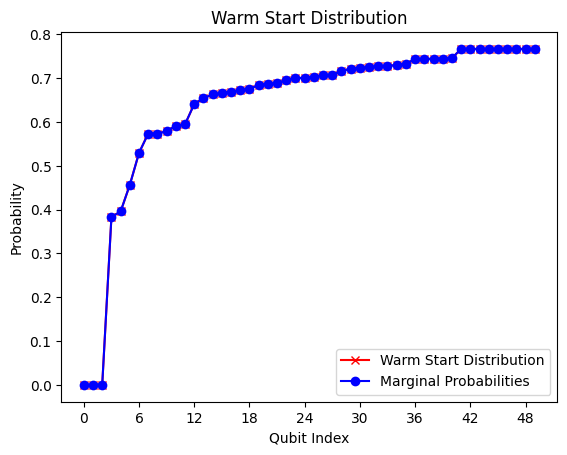

In [69]:
exact_estimator = StatevectorEstimator()
observables = [Pauli(f'I' * i + 'Z' + 'I' * (n - i - 1)) for i in range(n)]

def light_cone_estimate(qc, observable, estimator=exact_estimator):
    """
    Estimates the expectation value of the observable using the lightcone method.
    
    Args:
        qc (QuantumCircuit): The quantum circuit to run.
        observable (Pauli): The observable to estimate.
    
    Returns:
        float: The estimated expectation value.
    """

    pauli_str = observable.to_label()
    # print(f"Pauli string for the observable: {pauli_str}")

    # Find the non-trivial pauli operators in the observable and their indices
    non_trivial_pauli = pauli_str.replace('I', '')
    active_indices = [(len(pauli_str)-1-i) for i, p in enumerate(pauli_str) if p != 'I']
    # print(non_trivial_pauli)
    # print(active_indices)

    # Apply the light cone pass to the circuit
    light_cone_pass = LightCone(bit_terms=non_trivial_pauli, indices=active_indices)
    pm = PassManager([RemoveBarriers(),light_cone_pass])
    red_qc = pm.run(qc)

    # Now we've got to remove the unused wires from our circuit so that exact_estimator doesn't choke.
    # We do this by converting to a DAG, then identifying and removing the idle wires.
    # We also need to remove the corresponding Pauli operators from the observable. 
    # Note the remaining Pauli observable can be larger than non_trivial_pauli above, since it may contain
    # some I corresponding to qubits in the backwards lightcone of the active qubits.
    red_dag = circuit_to_dag(red_qc)
    qubits_to_remove = list(red_dag.idle_wires())
    indices_to_remove = [len(pauli_str) - 1 - red_dag.find_bit(q).index for q in qubits_to_remove]
    for q in qubits_to_remove:
        red_dag.remove_qubits(q)
    truncated_observable = Pauli(''.join([p for i, p in enumerate(pauli_str) if i not in indices_to_remove]))
    red_qc = dag_to_circuit(red_dag)

    # Run the estimator with the smaller circuit and the truncated observable.
    exact_sim = exact_estimator.run([(red_qc, truncated_observable)])
    
    return exact_sim.result()[0].data.evs

# Get Pauli Z expectation values (exact) using the lightcone method, then convert to probabilities
pauli_z_evs = [light_cone_estimate(qc, obs) for obs in observables]
marginal_probs = (1 - np.array(pauli_z_evs)) / 2

# Plot probabilities and compare with warm start distribution. Note we have to reverse the order of the qubits due to little-endian ordering.
plt.plot(qubit_ordered_distribution[::-1], marker='x', linestyle='-', color='red', label='Warm Start Distribution')
plt.plot(marginal_probs, marker='o', linestyle='-', color='blue', label='Marginal Probabilities')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Warm Start Distribution')
plt.xlabel('Qubit Index')
plt.ylabel('Probability')   
plt.legend()
plt.show()


# print(f"Marginal probabilities: {maginal_probs}")
# print(f"Warm Start Distribution: {qubit_ordered_distribution}")
# print(f"Test Exact Simulation Result: {test_exact_sim}")


#compare with  estimator
# exact_sim_estimate = exact_estimator.run([(qc, observables[3])]).result()[0].data.evs
# print(f"Exact Simulation Result: {exact_sim_estimate}")
#compare with probability distribution
# print(f"Should be equal to: {qubit_ordered_distribution[0]}")

# print(exact_sim.result()[0])

## The Copula Mixer

Now that we have initialized the warm start distribution on a quantum computer, we can use standard optimization techniques to try and shift the state towards an optimal (or near-optimal) knapsack solution. But if we try to apply standard QAOA techinques we encounter a problem. The knapsack problem is a constrained optimization problem, while QAOA is most naturally suited to *unconstrained* otpmization. It is always possible to add constraints, in the form of a penalty term, to the QAOA cost function then proceed like normal. But this approach complicates the cost function, and may (for inequality constraints as in the knapsack problem) also requires introducing slack variables which drive up the qubit count.  

An alternate approach to constrained optimization is to modify the QAOA mixer, so that the mixer dynamics naturally respect the constraints of the problem. But pursuing this approach in the case of the knapsack problem requires performing coherent addition between the qubits, which is out of scope for current quantum hardware. 

Here we pursure an alternate approach -- proposed in https://arxiv.org/abs/2108.08805 -- in which we modify the mixer in a way that we hope will approximately respect the knapsack constraints. This is less costly then the approach described in the previous paragraph, but still gives a way of partially incorporating constraints into the QAOA framework. 

The basic building block of this appraoch is a two-qubit mixer which we call the Copula mixer. This mixer takes as input variabels $\theta, p_1,$ and $p_2$, in addition to a parameter $\beta$ which controls the mixer strength as in standard QAOA. To explain this mixer, we first define the *Copula Distribution* $p_{cop}$ to be a distribution over two bits with: 

$$
\begin{align}
p_{cop}(0,0) &= (1 - p_1)(1-p_2) + \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(0,1) &= (1 - p_1)(p_2) - \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(1,0) &= (p_1)(1-p_2) - \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(1,1) &= (p_1)(p_2) + \theta p_1 p_2(1 - p_1)(1-p_2)
\end{align}
$$

Straightforward computation shows that this distribution has single-bit marginal probabilities matching the proabilities $p_1$ and $p_2$ used in its definition. The $\theta$ parameter takes values in $[-1,1]$ and controls whether the two bits are correlated or anti-correlated in this distribution. When $\theta = -1$ bits are maximally anti-correlated, and $\theta = 1$ corresponds to bits being maximally correlated.  

Now we construct a unitary $R_{cop}$ satisfying $R_{cop}\ket{00} = \ket{p_{cop}}$ and define the mixer Hamiltoniaon $H_{cop} = -R_{cop}^\dagger (ZZ) R_{cop}$. Then the state $\ket{p_{cop}} = \sum_{x_1, x_2} \sqrt{p_{cop}(x_1,x_2)} \ket{x_1, x_2}$ is the ground state of the Hamiltonian with eigenvalue $-2$, and all other eigenstates have eigenvalue $\geq 0$. Finally, the Copula mixer in terms of $\beta$ is defined by 

$$
\begin{align}
U_{cop, \beta} = \exp(-i \beta H_{cop}).
\end{align}
$$

Note that setting $\beta = 0$ turns off the Copula mixer. Since the eigenvalues of $H_{cop}$ are multiples of two, **the mixer is period in $\beta$ with a periodicity of $\pi$**, i.e. we have $U_{cop, \ \beta} = U_{cop,\ \beta + \pi}$ for any $\beta$. 

In [70]:
def construct_cop(p_1, p_2, beta, theta = -1):
    """
    Constructs a two qubit copula mixer with the given parameters.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum on which we add the Copula mixer.
        p_1 (float): Probability p_1 in the definition of the copula mixer.
        p_2 (float): Probability p_2 in the definition of the copula mixer.
        beta (float): The strength of the copula mixer.
        theta (float): The theta parameter of the copula mixer, which controls whether qubits are correlated or anti-correlated. Should take values in [-1,1] and defaults to -1, which means maximum anticorrelation.

    Returns:
        QuantumCircuit: The quantum circuit with the copula mixer added.
    """

    # We first construct a rotation operator designed to rotate the |00> state to the |p_cop> state.
    rotation_circuit = QuantumCircuit(2)
    phi_1 = 2 * np.arcsin(np.sqrt(p_1))  
    p_2_given_1 = (p_1 * p_2 + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2))/ p_1
    phi_2_given_1 = 2 * np.arcsin(np.sqrt(p_2_given_1))
    p_2_given_not1 = ((1- p_1) * p_2 - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)) / (1 - p_1)
    phi_2_given_not1 = 2 * np.arcsin(np.sqrt(p_2_given_not1))

    rotation_circuit.ry(phi_1, 0)  # Rotate first qubit to the correct marginal distribution
    rotation_circuit.cry(phi_2_given_1, control_qubit=0, target_qubit=1)  # Create correct joint distribution if first qubit is |1>
    rotation_circuit.x(0)  # Flip qubit 1
    rotation_circuit.cry(phi_2_given_not1, control_qubit=0, target_qubit=1)  # Create correct joint distribution if first qubit is |0>
    rotation_circuit.x(0)  # Undo flip

    copula_mixer = QuantumCircuit(2)
    copula_mixer.compose(rotation_circuit.inverse(), inplace=True) # rotate |p_cop> to |00>
    copula_mixer.barrier()  
    # In this rotated basis, the copula mixer is diagonal, so we can impliment with RZ gates.
    copula_mixer.rz(-2* beta, 0)  
    copula_mixer.rz(-2 *beta, 1)  
    # Adam messed up and thought this should be the mixer for a bit.
    # copula_mixer.x(0)  # Flip qubit 1
    # copula_mixer.x(1)  # Flip qubit 1
    # # Apply the desired phase
    # copula_mixer.cp(2*beta, control_qubit=0, target_qubit=1)  # Apply the copula mixer phase
    # copula_mixer.x(0)  # Flip qubit 1
    # copula_mixer.x(1)  # Flip qubit 1
    copula_mixer.barrier()  
    copula_mixer.compose(rotation_circuit, inplace=True) # rotate |00> back to |p_cop>

    return copula_mixer
    

Now lets run some basic tests to verify the copula is working as intended. 

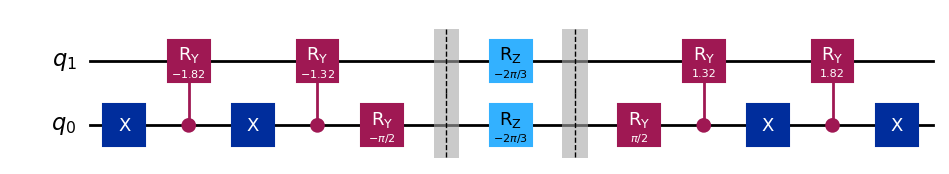

Eigenvalues of the copula mixer: 

Eigenvalue: 1.0000+0.0000j
Eigenvector: -0.7071+0.0000j |00>  + 0.0000+0.0000j |01> + 0.0000-0.0000j |10> + 0.7071+0.0000j |11>
Eigenvalue: -0.5000-0.8660j
Eigenvector: 0.5590+0.0000j |00>  + -0.4330-0.0000j |01> + -0.4330-0.0000j |10> + 0.5590+0.0000j |11>
Eigenvalue: -0.5000+0.8660j
Eigenvector: 0.4330+0.0000j |00>  + 0.5590+0.0000j |01> + 0.5590-0.0000j |10> + 0.4330+0.0000j |11>
Eigenvalue: 1.0000+0.0000j
Eigenvector: -0.1135-0.3189j |00>  + 0.6208+0.0000j |01> + -0.6208+0.0000j |10> + 0.1135+0.3189j |11>

We expect an eigenvector: 0.4330 |00> + 0.5590 |01> + 0.5590 |10> + 0.4330 |11>
with eigenvalue exp(2 i beta) = exp( 2 pi i / 3) = -0.5000+0.8660j


In [71]:
# Test the copula mixer construction.
test_copula_mixer = construct_cop(0.5, 0.5, np.pi/3)

display(test_copula_mixer.draw('mpl', scale=1, idle_wires=False, fold=-1, reverse_bits=True))

# This unitary is small enough we can just check its eigenvectors and eigenvalues directly. 
cop_unitary = Operator(test_copula_mixer).data
eigenvalues, eigenvectors = np.linalg.eig(cop_unitary)

print("Eigenvalues of the copula mixer: \n")
for i, ev in enumerate(eigenvalues):
    print(f"Eigenvalue: {ev:.4f}")
    print(f"Eigenvector: {eigenvectors[0,i]:.4f} |00>  + {eigenvectors[1,i]:.4f} |01> + {eigenvectors[2,i]:.4f} |10> + {eigenvectors[3,i]:.4f} |11>")  


p_1 = 0.5
p_2 = 0.5
theta = -1
p_cop_00 = (1 - p_1) * (1 - p_2) + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_01 = (1 - p_1) * p_2 - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_10 = p_1 * (1 - p_2) - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_11 = p_1 * p_2 + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)

print(f"\nWe expect an eigenvector: {np.sqrt(p_cop_00):.4f} |00> + {np.sqrt(p_cop_01):.4f} |01> + {np.sqrt(p_cop_10):.4f} |10> + {np.sqrt(p_cop_11):.4f} |11>")
print(f"with eigenvalue exp(2 i beta) = exp( 2 pi i / 3) = {np.exp(2j * np.pi / 3):.4f}")


Now we can construct the "ring" copula mixer proposed in https://arxiv.org/pdf/2108.08805. The idea is to visualize the qubits as lying in a ring, and to apply the two qubit copula mixer defined above between nearest neighbour terms on the ring. We get the probabilities $p_i$ and $p_j$ used in the defintion of each copula mixer from the warm start distribution we used to initialize our quantum state. 

This should have the effect of leaving the qubits with high ratios of value-to-weight as very likely in the knapsack, anad the low ratio qubits as very likely excluded from the knapsack, but it will encourage mixing between the qubits with middling value. This mixing should anti-correlate nearby terms -- adding a item to the knapsack while removing an item with similar ratio -- and thus approximately preserve the overall knapsack weight.

In [72]:
def add_ring_copula(quantum_circuit, probability_dist, beta):
    """
    Constructs a ring copula mixer on the given quantum circuit.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to which we add the ring copula mixer.
        probability_dist (np.ndarray): The probability distribution to use for the copula mixer.
    """
    n = len(probability_dist)
    for i in range(1,n,2):
        p_1 = probability_dist[i]
        p_2 = probability_dist[(i + 1) % n]
        copula_mixer = construct_cop(p_1, p_2, beta)
        quantum_circuit.compose(copula_mixer, qubits=[i, (i + 1) % n], inplace=True)

    for i in range(2,n,2):
        p_1 = probability_dist[i]
        p_2 = probability_dist[(i + 1) % n]
        copula_mixer = construct_cop(p_1, p_2, beta)
        quantum_circuit.compose(copula_mixer, qubits=[i, (i + 1) % n], inplace=True)

    quantum_circuit.barrier()  
    return quantum_circuit

To complete the setup for xQAOA we also need to define a cost function. Because we have encoded a (soft) version of our constraints into our mixer we leave constraints out of this cost function. But then it is particularly straightfoward -- we simply sum the values of each of the items included in the knapsack. 

As in standard QAOA we also multiple our cost function by a $\gamma$ parameter. Because we want this parameter to take values in $[0,2\pi]$, we will normalize all our values by the max possible value so the normalized values lie in $[0,1]$. 

In [73]:
def add_knapsack_cost_function(quantum_circuit, values, gamma):
    """
    Adds a cost function to the quantum circuit that sums the values of the items included in the knapsack.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to which we add the cost function.
        values (np.ndarray): The values of the items in the knapsack.
        gamma (float): The strength of the cost function.
    """

    max_value = np.max(values)
    n = len(values) 
    for i in range(n):
        quantum_circuit.p(gamma * values[i]/max_value, i)  # Apply RZ gate with angle proportional to value
    quantum_circuit.barrier()  # Add a barrier for clarity in the circuit diagram.
    return quantum_circuit

Finally, we can put this all together and visualize the circuit with the warm start initialization, one layer of the cost unitary, and one layer of the mixer. 

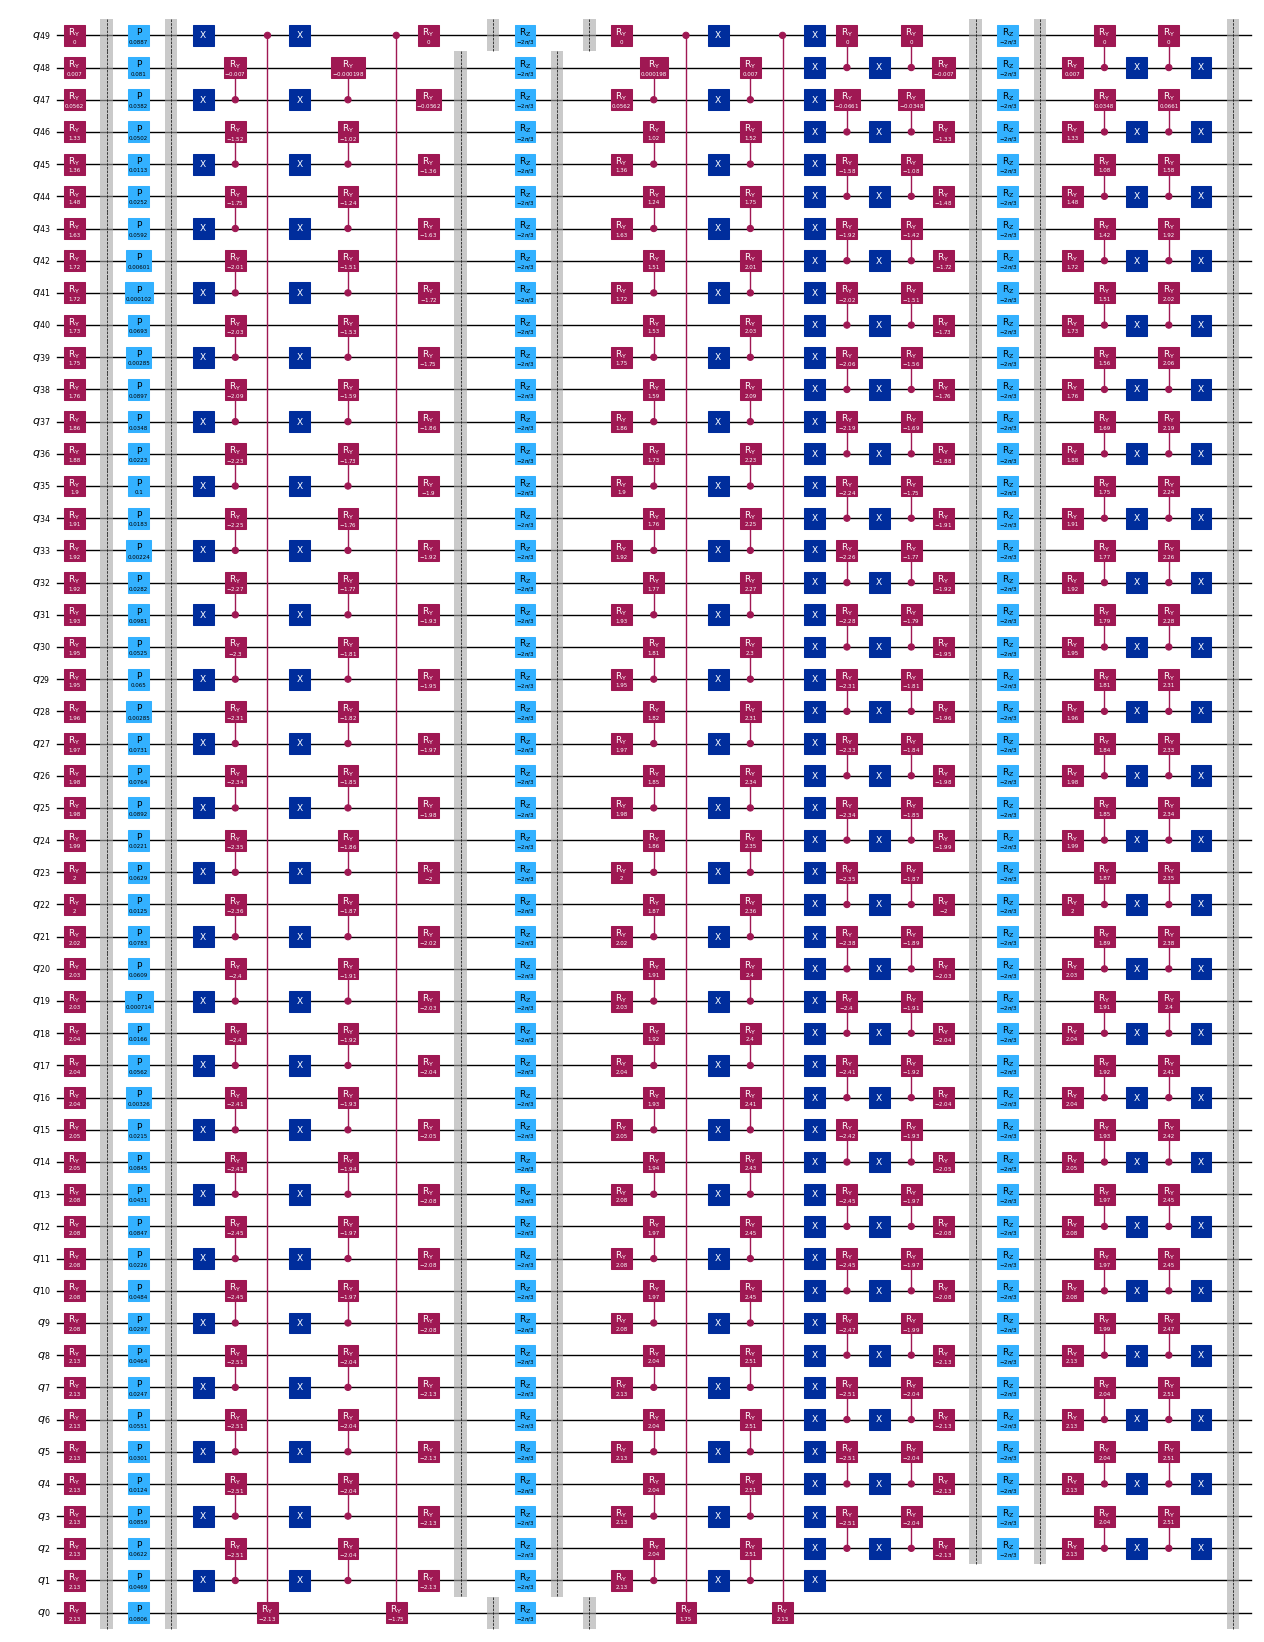

In [74]:
# Now lets plot a sample of our circuit with one layer of the ring copula mixer. 
# Picking arbitrary values of beta and gamma for now.
qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)
qc = add_knapsack_cost_function(qc, values, 0.1)
qc = add_ring_copula(qc, qubit_ordered_distribution, np.pi/3)
qc.draw('mpl', scale=0.5, idle_wires=False, fold=-1, reverse_bits=True)

## Optimizing Values of Beta and Gamma

### Defining the Objective to Optimize 

Now that our basic circuit is set up, we can turn our attention to the important task of optimizing its variational paramters. The first question to consider is what function we want to optimize. In standard QAOA, the cost function being optimized is the same one which is expoentiated to produce the cost unitary, and that is an option for us as well. 

But there are other options -- we can incorporate the knapsack constraints in the final cost function we optimize against (even though we left them out of the cost unitary). One natural way to do this that avoids the need for slack variables is just to enforce an *equality* constraint -- that the total weight of items in the knapsack match its capacity -- with a penalty term which increases the more this constaint is violated. 

We will define cost functions (expressed as weighted sums of Pauli operators) corresponding to the two approaches above. One nice feature of both these cost functions is that they can be expressed as sums of low weight Pauli operators, meaning that they can be estimated using the lightcone methods defined earlier. 

The first option -- defining a cost function without constraints -- is straightforward. Letting $x_i$ be the indicator random variable indicating if item $i$ is in the knapsack, and $v_i$ be the value of each item in our knapsack. Then our cost function just tries to maximize the value of items in the knapsack:

$\begin{align}
f_{cost}(x) = \sum_i x_i v_i.
\end{align}$

By we can express the expected value of indicator random variable $x_i$ in terms of the expectation value of a Pauli $Z_i$ operating on the $i$-th qubit: $\langle x_i \rangle = \langle (1 - Z_i)/2 \rangle$. So we can also express our cost an sum of Pauli terms which, when measured, gives us the expected cost. 

$\begin{align}
f_{cost}(Z) = \sum_i v_i (1 - Z_i)/2 = \sum_i (-v_i) Z_i / 2 + \text{const}.
\end{align}$

Since the constant terms and multiplicative factors do not affect the overall optimization, we optimize the simpler cost function 

$\begin{align}
f_{cost}(Z) = \sum_i (-v_i) Z_i.
\end{align}$


In [75]:
def values_only_cost(values):
    """
    Constructs a cost function that sums the values of the items included in the knapsack.
    
    Args:
        values (np.ndarray): The values of the items in the knapsack.
        
    Returns:
        SparsePauliOp: A sparse Pauli operator representing the cost function.
    """

    PauliZ_obs = [Pauli(f'I' * i + 'Z' + 'I' * (n - i - 1)) for i in range(len(values))]    
    Weights = -values[::-1]  # Reverse the order of the values to match little-endian ordering
    return SparsePauliOp(PauliZ_obs, Weights)

The second option -- defining a cost function which includes a soft equality constraint -- requires some more math. We let $v_i$ denot the value of the $i$-th knapsack item, $w_i$ denote its weight, C be the knapsack capacity and $x_i$ be an indicator random variable indicating whether item $i$ is in the knapsack. Then the cost function we would like to impliment has the form: 

$\begin{align}
f_{cost}(x) = \sum_i x_i v_i - \chi \left( \sum_i x_i w_i - C \right)^2.
\end{align}$

where $\chi$ is a free parameter determining the strength of our equality constraint. We can expand this expression to obtain

$\begin{align}
f_{cost}(x) = \sum_i x_i v_i - \chi \left( \sum_i \sum_j x_i x_j  w_i x_j - 2 C \sum_i x_i w_i + C^2 \right).
\end{align}$

We drop the constant term (since it has no effect on the overall optimization) and replace the other terms with Pauli operators as $x_i = (1 - Z_i)/2$ to obtain

$\begin{align}
f_{cost}(Z) &= \sum_i v_i (1 - Z_i) / 2 - \chi \left( \sum_i \sum_j w_i w_j (1 - Z_i)(1-Z_j) / 4 - C \sum_i w_i (1- Z_i) \right) \\
&= \sum_i -v_i Z_i / 2 - \chi \left(  \sum_i \sum_j w_i w_j (Z_i Z_j - Z_i - Z_j) / 4 + C \sum_i w_i Z_i \right).
\end{align}$

We introduce the shorthand $W = \sum_i w_i$ and continue:

$\begin{align}
f_{cost}(Z) &= \sum_i -v_i Z_i / 2 - \sum_i \sum_j \chi w_i w_j Z_i Z_j + \sum_i \sum_j \chi w_i w_j Z_i / 2 - C \chi \sum_i w_i Z_i \\
&= \sum_i -v_i Z_i / 2 - \sum_i \sum_j \chi w_i w_j Z_i Z_j + \sum_i \chi w_i W Z_i / 2 - C \chi \sum_i w_i Z_i \\
&= \sum_{i \neq j} \chi w_i w_j Z_i Z_j + \sum_i Z_i (-v_i/2 + \chi (W/2 - C) w_i).
\end{align}$

In the final line we noticed that $Z_i^2 = I$ and shifted by a constant to remove terms where $i = j$ in the first sum. Also we note that the sum as written above ``double counts'' $i,j$ and $j,i$, so we need to include a factor of two in the first term if we want a sum that only includes each $Z_i Z_j$ once. 

We end with a discussion of reasonable values for $\chi$. For now, we will make this number reasonably small to encourage exploration. Our optimal solutions seem to have a weight about 10 away from the knapsack capacity. We set $\chi = 500 * (1/100)^2 = 0.05$, so that having a solution a weight 100 away from optimal is penalized about the same as excluding an item with average value in the distribtuion. 

Now we construct the corresponding Sparse Pauli Operator.

In [76]:
def values_and_constraint_cost(values, weights, capacity, chi = 0.05):
    """
    Constructs a cost function that sums the values of the items included in the knapsack.
    
    Args:
        values (np.ndarray): The values of the items in the knapsack.
        weights (np.ndarray): The weights of the items in the knapsack.
        capacity (float): The capacity of the knapsack.
        chi (float): A parameter controlling how strongly solutions are penalized for not using the full knapsack capacity. Defaults to 0.05.

    Returns:
        SparsePauliOp: A sparse Pauli operator representing the cost function.
    """

    PauliZ_obs = [Pauli(f'I' * i + 'Z' + 'I' * (n - i - 1)) for i in range(len(values))]    
    PauliZZ_obs = []
    for i in range(len(values)):
        for j in range(i + 1, len(values)):
            PauliZZ_obs.append(Pauli(f'I' * i + 'Z' + 'I' * (j - i - 1) + 'Z' + 'I' * (n - j - 1)))
    weights_sum = np.sum(weights)
    singleZ_coeff = -values[::-1]/2 + chi * (weights_sum/2 - capacity) * weights[::-1]  
    doubleZ_coeff = []
    for i in range(len(values)):
        for j in range(i + 1, len(values)):
            doubleZ_coeff.append(2 * chi * weights[len(values) - i - 1] * weights[len(values) - j - 1])
    observables = PauliZ_obs + PauliZZ_obs
    # print(f"Single Z coefficients: {singleZ_coeff}")
    # print(f"Double Z coefficients: {doubleZ_coeff}")
    # doubleZ_coeff = np.array(doubleZ_coeff)
    # print(f"double Z coefficients: {doubleZ_coeff}")
    coefficients = np.concatenate((singleZ_coeff, doubleZ_coeff))
    return SparsePauliOp(observables, coefficients)

Now that both our objectives are defined, we can use the lightcome estimator defined previously to compute the objective function for given values of $\gamma$ and $\beta$. Some sample calculations are below.

In [77]:
def light_cone_estimate_sparse_pauli(qc, observable, estimator=exact_estimator):
    """
    Estimates the expectation value of the observable using the lightcone method.
    
    Args:
        qc (QuantumCircuit): The quantum circuit to run.
        observable (SparsePauliOp): The observable to estimate.
    
    Returns:
        float: The estimated expectation value.
    """

    Pauli_list = observable.paulis
    coefficient_list = observable.coeffs

    # print(Pauli_list)
    # print(coefficient_list)

    Pauli_evs = [light_cone_estimate(qc, Pauli) for Pauli in Pauli_list]
    
    #print(Pauli_evs)

    return np.sum(np.array(Pauli_evs) * np.array(coefficient_list)) 

print("Testing light cone estimate with various cost functions...")
start_time = time.time()
ev = light_cone_estimate_sparse_pauli(qc, values_only_cost(values))
end_time = time.time()
print(f"Values only cost function: {ev:.4f}, computed in {end_time - start_time:.4f} seconds")

start_time = time.time()
ev2 = light_cone_estimate_sparse_pauli(qc, values_and_constraint_cost(values, weights, capacity))
end_time = time.time()
print(f"Values and constraint cost function: {ev2:.4f}, computed in {end_time - start_time:.4f} seconds")

Testing light cone estimate with various cost functions...
Values only cost function: 4116.6467+0.0000j, computed in 0.3410 seconds
Values and constraint cost function: 1539992.2597+0.0000j, computed in 16.1948 seconds


The values only calculation is fast enough that we can plot a heatmap showing how performance varies with values of $\beta$ and $\gamma$. The values and constraint cost function seems slightly too slow to be usable in practice. 

In [82]:
beta_range = np.linspace(0, np.pi, 100)
gamma_range = np.linspace(0, 2 * np.pi, 100)

ev = np.array(np.zeros((len(beta_range), len(gamma_range))), dtype=float)

for i,j in tqdm(np.ndindex(len(beta_range), len(gamma_range))):
    qc = QuantumCircuit(n)
    qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)
    qc = add_knapsack_cost_function(qc, values, gamma_range[j])
    qc = add_ring_copula(qc, qubit_ordered_distribution, beta_range[i])
    ev[i][j] = light_cone_estimate_sparse_pauli(qc, values_only_cost(values))

print(ev)



0it [00:00, ?it/s]

C:\Users\adamb\AppData\Local\Temp\ipykernel_5792\935025545.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  ev[i][j] = light_cone_estimate_sparse_pauli(qc, values_only_cost(values))
10000it [3:16:24,  1.18s/it]

[[5713.44490479 5713.44490479 5713.44490479 ... 5713.44490479
  5713.44490479 5713.44490479]
 [5711.3646302  5782.96067904 5854.38860753 ... 5064.88948578
  5071.73913074 5080.90943775]
 [5705.11918359 5847.15668374 5988.7627217  ... 4334.27643029
  4350.21720525 4370.67618626]
 ...
 [5705.11918359 5562.88964422 5420.70710616 ... 6721.52307193
  6715.21678691 6704.06849606]
 [5711.3646302  5639.72068874 5568.14898342 ... 6268.86672309
  6264.44032153 6257.61149512]
 [5713.44490479 5713.44490479 5713.44490479 ... 5713.44490479
  5713.44490479 5713.44490479]]


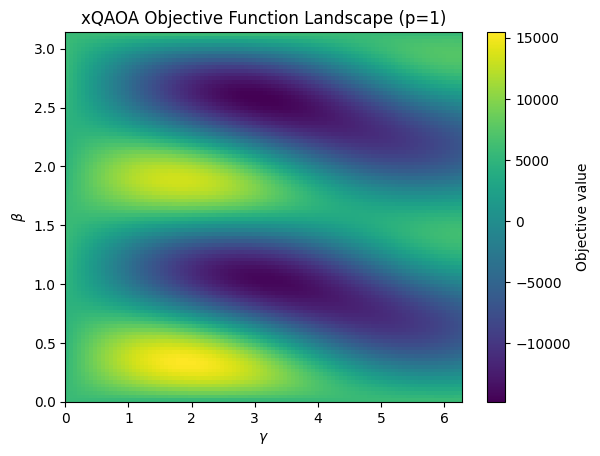

In [85]:
plt.imshow(ev, origin='lower', aspect='auto', cmap='viridis', extent = (0, 2 * np.pi, 0, np.pi))
plt.colorbar(label='Objective value')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.title("xQAOA Objective Function Landscape (p=1)")
plt.show()

## WIP -- IGNORE FOR NOW

A final approach would be to enforce the knapsack constraint properly as an *inequality* constraint, again with some penalty term. Because this would only be enforced in the final cost function it would not increase the depth of the quantum circuit. But the inequality constraint cannot be expressed as a low degree sum of Pauli operators, and so cannot be computed using the lightcone methods described above. 

As a workaround, we can instead inforce that the *average* weight of the solution provided lies below the capacity of the knapsack. That is, we can set our cost function to be:

$\begin{align}
f_{cost}(x) = \sum_i x_i v_i + \chi I\big[ \langle x \rangle > C\big]
\end{align}$

This approach has some obvious limitations as compared to the standard approach where we check the weight of each solution individually. As a extreme example, a probabilitic solution which fills the knapsack half the time and empties the knapsack half the time will have an average weight  

## Bug/concerns as compared to main code:

* Value of $r^*$ when defining the smoothed lazy greedy distribution. Should be set so that at $k = \infty$ we arrive at the lazy greedy distribuion (see Alg 6 in https://arxiv.org/pdf/2108.08805). But in qkp.solver.py it looks like it's just set to the average. 

* Qubits should be ordered so that adjacent qubits have similar ratios before applying Copula mixer. See discussion in 5.2.3 in (https://arxiv.org/pdf/2108.08805).

* I had to fiddle a bit to get the lightcone estimator to delete unused qubits and corresponding 'I' terms in the observables. It's unclear to me if this is faster (maybe StatevectorEstimator clears these automatically?), but my computer was throwing some index out of bounds error for larger qubit counts without that step. Makes me think StatevectorEstimator is carrying around more info than it needs to without manually deleting idle qubits.

* Order of operations in the copula mixer seems backwards. We want R_12^dagger (Z rotations) R_12, because we want to first rotate |p_12> to the |00> state, then apply Z operations, then rotate back. 

* (As far as I could tell, not discussed in https://arxiv.org/pdf/2108.08805.) We rescaled values when defining the cost unitary in xQAOA so that values were in $[0,1]$. 

[** NOT A BUG, paper is correct. But this is an alternate, potentially interesting mixer: ]: #
[Bug in https://arxiv.org/pdf/2108.08805! B_{p_12} as defined is not unitary (has "0" eigenvalues) and the described circuit does not satisfy the constraints in eq.24. Instead I'm using a controlled phase gate to construct a circuit satisfying eq.24. But it's worth comparing that with the copula mixer as defined in the paper.]: #
